In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import random
import pickle
import joblib

In [2]:
data_paths = "/content/drive/My Drive/Datasets_New"
spam_path = data_paths + "/fakeImages"
normal_path = data_paths + "/trueImages"

In [3]:
print(data_paths,spam_path,normal_path)

/content/drive/My Drive/Datasets_New /content/drive/My Drive/Datasets_New/fakeImages /content/drive/My Drive/Datasets_New/trueImages


In [4]:
labels = []
training_labels = []
test_labels = []
training_images = []
testing_images =[]

In [5]:
imagePaths = list(paths.list_images(data_paths))


In [6]:

data = []
labels = []
random.shuffle(imagePaths)
# loop over the image paths
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2][:-6]
  value = 1 if label == 'true' else 0
  print(imagePath)
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(value)
print(labels[:5])


/content/drive/My Drive/Datasets_New/fakeImages /fake124.jpg
/content/drive/My Drive/Datasets_New/fakeImages /fake63.jpg
/content/drive/My Drive/Datasets_New/fakeImages /images (2).jpeg
/content/drive/My Drive/Datasets_New/trueImages/15may_lf_eggscerealorfruit.jpg
/content/drive/My Drive/Datasets_New/fakeImages /acne.jpg
/content/drive/My Drive/Datasets_New/trueImages/true39.jpg
/content/drive/My Drive/Datasets_New/fakeImages /maxresdefault.jpg
/content/drive/My Drive/Datasets_New/trueImages/Main_cooking-food-prep-vegetables-colourful-1024x683-1.jpg
/content/drive/My Drive/Datasets_New/trueImages/493ss_thinkstock_rf_photo_of_berry_smoothie.jpg
/content/drive/My Drive/Datasets_New/trueImages/tue31.jpg
/content/drive/My Drive/Datasets_New/fakeImages /5898a44d8275e829008b47f2.jpg
/content/drive/My Drive/Datasets_New/fakeImages /fake79.jpg
/content/drive/My Drive/Datasets_New/fakeImages /fake118.jpg
/content/drive/My Drive/Datasets_New/fakeImages /Fake-transformation-by-Melanie-Ventura.jpg

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
print(np.shape(data))
print(labels)

(288, 224, 224, 3)
[0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0]


In [9]:
print(np.shape(labels))

(288,)


In [10]:
(training_images, testing_images, training_labels, testing_labels) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [16]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [17]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(training_images, training_labels, batch_size=BS),
	steps_per_epoch=len(training_images) // BS,
	validation_data=(testing_images, testing_labels),
	validation_steps=len(testing_images) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
7/7 [==============================] - 14s 2s/step - loss: 0.7019 - accuracy: 0.5893 - val_loss: 0.5335 - val_accuracy: 0.7759
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.5147 - accuracy: 0.8047 - val_loss: 0.4971 - val_accuracy: 0.7586
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.5390 - accuracy: 0.7555 - val_loss: 0.4461 - val_accuracy: 0.7759
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.3750 - accuracy: 0.8721 - val_loss: 0.3987 - val_accuracy: 0.8103
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.3526 - accuracy: 0.8454 - val_loss: 0.3444 - val_accuracy: 0.8448
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.3384 - accuracy: 0.8602 - val_loss: 0.3039 - val_accuracy: 0.8448
Epoch 7/20
7/7 [==============================] - 10s 2s/step - loss: 0.2582 - accuracy: 0.9271 - val_loss: 0.2842 - val_accuracy: 0.8621
Epoch 8/20

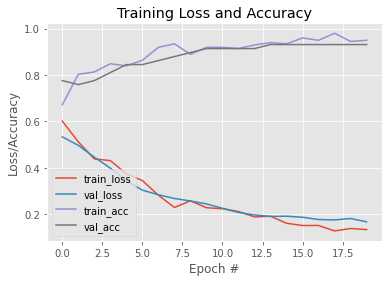

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [19]:
predIdxs = model.predict(testing_images[:10], batch_size=BS)
for i in predIdxs:
  if i > 0.5:
    print("TRUE")
  else:
    print("FAKE")


TRUE
FAKE
FAKE
FAKE
TRUE
FAKE
FAKE
FAKE
FAKE
FAKE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


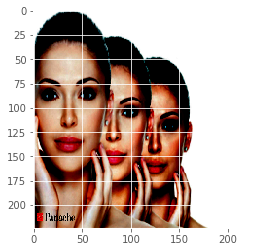

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00543281]]
FAKE


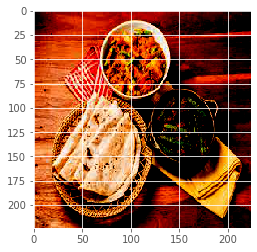

[[0.9910319]]
TRUE


In [20]:
from PIL import Image
from matplotlib import pyplot as plt



check = []
check2 = []
test_path= "/content/drive/My Drive/Datasets_New/fakeImages /fake124.jpg"
test2_path="/content/drive/My Drive/Datasets_New/trueImages/true42.jpg"

image = load_img(test_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

check.append(image)
check= np.array(check, dtype="float32")
temp1 = check.reshape(224,224,3)
plt.imshow(temp1, interpolation='nearest')
plt.show()
print(model.predict(check))
print( "TRUE" if model.predict(check) > 0.5 else "FAKE")

image = load_img(test2_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

check2.append(image)
check2= np.array(check2, dtype="float32")
temp2 = check2.reshape(224,224,3)
plt.imshow(temp2, interpolation='nearest')
plt.show()
print(model.predict(check2))
print( "TRUE" if model.predict(check2) > 0.5 else "FAKE")
  



In [23]:
import pandas as pd
df = pd.DataFrame()

In [25]:
data_paths = "/content/drive/My Drive/Test_Images/test"
imagePaths = list(paths.list_images(data_paths))
ans = []

for i in imagePaths:
  image = load_img(i, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  check2 = []
  check2.append(image)
  check2= np.array(check2, dtype="float32")
  ans.append(model.predict(check2))

df['Image_Score']=ans


In [26]:
df.to_csv(r'/content/imagescore.csv')